<a href="https://colab.research.google.com/github/nickymind/BDWBA2K19/blob/master/CLTVv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de CLTV

## Importo Dataset de Features de Clientes y su Valoración

In [45]:
import pandas as pd
import numpy as np

In [46]:
import pkgutil
import encodings
import os

def all_encodings():
    modnames = set([modname for importer, modname, ispkg in pkgutil.walk_packages(
        path=[os.path.dirname(encodings.__file__)], prefix='')])
    aliases = set(encodings.aliases.aliases.values())
    return modnames.union(aliases)

text = b'\x96'
for enc in all_encodings():
    try:
        msg = text.decode(enc)
    except Exception:
        continue
    if msg == 'ñ':
        print('Decoding {t} with {enc} is {m}'.format(t=text, enc=enc, m=msg))

Decoding b'\x96' with mac_romanian is ñ
Decoding b'\x96' with mac_turkish is ñ
Decoding b'\x96' with mac_arabic is ñ
Decoding b'\x96' with mac_farsi is ñ
Decoding b'\x96' with mac_croatian is ñ
Decoding b'\x96' with mac_iceland is ñ
Decoding b'\x96' with mac_roman is ñ


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: unicode_internal codec has been deprecated
  


In [47]:
# Busco directorio actual
#import os
#print(os.getcwd())
#os.chdir("/Users/nicolashmartins/OneDrive - Banco Macro S.A/Tesis ITBA/QUERIES/")
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [6]:
#dataset= pd.read_csv('GENERACION_DATASET201901v2.csv', encoding='latin1', sep=';')

In [7]:
path = "/content/drive/MyDrive/Data/GENERACION_DATASET201901v2.csv"
dataset = pd.read_csv(path)
# Dataset is now stored in a Pandas Dataframe

## Análisis Descriptivo Exploratorio

In [49]:
dataset.head(4)

,PERIODO,CODIGO_CLIENTE,CLI_INDICE_CROSS_SELL,CLI_ANTIG_CLIENTE_PROD_VIGENTES,CLI_POSICION_PASIVA,CLI_POSICION_ACTIVA,CLI_SEXO,EDAD,CLI_CATEGORIA,CLI_SITUACION_BCRA,CLI_SUCURSAL_SOURCE_RADICACION,CLI_CODIGO_IVA,CLI_SEGMENTO,CLI_SUB_SEGMENTO,CLI_SEGMENTO_COMERCIAL,CLI_SUB_SEGMENTO_COMERCIAL,CLI_SCORE_DATOS_ADICIONALES,CLI_CANTIDAD_EMPLEADORES,FLAG_CUIT_EMPLEADOR,CLI_INGRESO_CONSIDERADO,CLI_INGRESO,ACRED_CUPONES_ULT_3,ANTERIOR_CC_VIGENTE,FLAG_TIENE_ANTERIOR_CC_VIG,ULTIMA_CC_VIGENTE,FLAG_TIENE_ULTIMA_CC_VIG,FLAG_CALIF_CTE,CC,DV_ANT_SALDO_NEGATIVO_3,DV_ANT_SALDO_NEGATIVO_6,DV_ANT_SALDO_NEGATIVO_12,DV_ANT_SALDO_POSITIVO_3,DV_ANT_SALDO_POSITIVO_6,DV_ANT_SALDO_POSITIVO_12,DV_PROM_SALDO,DV_PROM_SALDO_3,DV_PROM_SALDO_6,DV_PROM_SALDO_12,DV_CA_ACRED,DV_CA_EXTRAC,...,DV_CA_ACRED_3,DV_CA_EXTRAC_3,DV_CA_MONTO_TRANS_3,FLAG_COMPRA_TD,CLI_DIAS_MORA,CLI_SALDO_DEUDA,CLI_DIAS_SOBREGIRO,CLI_DIAS_ATRASO_BCRA,CLI_FLAG_SITUACION_BANCO_1_3,CLI_FLAG_SITUACION_BANCO_2_3,CLI_FLAG_SITUACION_BANCO_3_3,PF_SALDO,PF_CANT,PF_SALDO_3,PF_CANT_PROM_3,PR_HIPOTECARIOS,PR_PERSONALES,PR_ATRASO_30,PR_ATRASO_60,PR_MONTO_ORIGINAL,PR_MESES_CON_PRESTAMOS,PR_ANTIGUEDAD_PRESTAMOS,PR_MESES_ENTRE_PRESTAMOS,PR_MESES_CON_PERSONALES,PR_PORC_RENOVADOS_RECIENTE,PR_Q_RENOVADOS_RECIENTE,FLAG_CUENTA_TC,FLAG_CA,FLAG_CA_USD,FLAG_CC,FLAG_TD,FLAG_SEGURO,FLAG_PAQUETE_BI,VALOR_PROPIO_PROM_1,VALOR_PROPIO_PROM_3,VALOR_PROPIO_PROM_6,VALOR_PROPIO_PROM_12,VALOR_PROPIO_PROM_1.1,VALOR_PROPIO_PROM_3.1,DIVISION_SUCURSAL
0,201810,196,1,41,25056.09,0.00,M,83,No Categorizado,Cliente sin deuda,13,CONF,Jubilados/Pensionados,Jubilados/Pensionados Anses,MERCADO ABIERTO,MERCADO ABIERTO,0.0,0,0,SIN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,12.0,12.0,12.0,0.0,0.0,0.0,25125.78,25031.40,24601.13,23850.78,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,630.85,577.91,527.58,431.86,804.26,747.29,NEA
1,201810,192,3,199,7.97,5522.94,M,47,Individuos,1. En situaci_n y cumplimiento normal,18,CONF,Jubilados/Pensionados,Jubilados/Pensionados Anses,JUBILADOS,PENSION GRACIABLE,0.0,0,0,CC,7161.0,0,NaN,NaN,NaN,NaN,0,NaN,12.0,12.0,12.0,0.0,0.0,0.0,231.67,425.78,649.24,680.38,1.0,2.0,...,3.0,6.0,0.0,1,0.0,5522.94,0.0,0.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,13000.0,61.0,60.0,0.0,61.0,0.0,0.0,1,1,0,1,1,1,1,119.26,108.99,103.84,91.37,379.48,207.32,NEA
2,201810,95,2,175,58818.93,0.00,M,76,No Categorizado,Cliente sin deuda,27,INSC,Profesionales Y Negocios,"Prod. Tabacaleros, Yerbateros",JUBILADOS,JUBILADOS NACIONALES,0.0,0,0,CC,8029.0,0,NaN,NaN,NaN,NaN,0,NaN,12.0,12.0,12.0,0.0,0.0,0.0,66455.22,131153.81,160962.94,137332.70,1.0,2.0,...,1.0,2.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1,1,0,0,1926.99,3223.63,3680.99,2871.87,5571.99,4303.49,NEA
3,201810,94,1,189,366.48,0.00,F,66,No Categorizado,Cliente sin deuda,5,CONF,Plan Sueldo,Empresas Privadas A,JUBILADOS,JUBILADOS NACIONALES,0.0,0,0,CC,11203.0,0,41.0,1.0,41.0,1.0,0,NaN,12.0,12.0,12.0,0.0,0.0,0.0,1158.33,931.40,1303.35,12770.62,1.0,6.0,...,3.0,12.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,1,0,0,-66.99,-43.76,-32.46,89.32,-4.92,44.48,NEA


In [50]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238751 entries, 0 to 238750
Data columns (total 81 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   PERIODO                          238751 non-null  int64  
 1   CODIGO_CLIENTE                   238751 non-null  int64  
 2   CLI_INDICE_CROSS_SELL            238751 non-null  int64  
 3   CLI_ANTIG_CLIENTE_PROD_VIGENTES  238751 non-null  int64  
 4   CLI_POSICION_PASIVA              238751 non-null  float64
 5   CLI_POSICION_ACTIVA              238751 non-null  float64
 6   CLI_SEXO                         238751 non-null  object 
 7   EDAD                             238751 non-null  int64  
 8   CLI_CATEGORIA                    238751 non-null  object 
 9   CLI_SITUACION_BCRA               238751 non-null  object 
 10  CLI_SUCURSAL_SOURCE_RADICACION   238751 non-null  int64  
 11  CLI_CODIGO_IVA                   238751 non-null  object 
 12  CL

In [55]:
dataset.dtypes

PERIODO                              int64
CODIGO_CLIENTE                       int64
CLI_INDICE_CROSS_SELL                int64
CLI_ANTIG_CLIENTE_PROD_VIGENTES      int64
CLI_POSICION_PASIVA                float64
                                    ...   
VALOR_PROPIO_PROM_6                float64
VALOR_PROPIO_PROM_12               float64
VALOR_PROPIO_PROM_1.1              float64
VALOR_PROPIO_PROM_3.1              float64
DIVISION_SUCURSAL                   object
Length: 81, dtype: object

In [56]:
# Analizo valores nulos en dataset
dataset.isnull().sum()

PERIODO                            0
CODIGO_CLIENTE                     0
CLI_INDICE_CROSS_SELL              0
CLI_ANTIG_CLIENTE_PROD_VIGENTES    0
CLI_POSICION_PASIVA                0
                                  ..
VALOR_PROPIO_PROM_6                0
VALOR_PROPIO_PROM_12               0
VALOR_PROPIO_PROM_1.1              0
VALOR_PROPIO_PROM_3.1              0
DIVISION_SUCURSAL                  0
Length: 81, dtype: int64

In [57]:
# Analizo si hay datos duplocados
len(dataset['CODIGO_CLIENTE'].unique())

238751

In [58]:
len(dataset) - len(dataset['CODIGO_CLIENTE'].unique())

0

In [59]:
# Calculo las medidas de estadística descriptiva de las variables del dataset
dataset.describe()

,PERIODO,CODIGO_CLIENTE,CLI_INDICE_CROSS_SELL,CLI_ANTIG_CLIENTE_PROD_VIGENTES,CLI_POSICION_PASIVA,CLI_POSICION_ACTIVA,EDAD,CLI_SUCURSAL_SOURCE_RADICACION,CLI_SCORE_DATOS_ADICIONALES,CLI_CANTIDAD_EMPLEADORES,FLAG_CUIT_EMPLEADOR,CLI_INGRESO,ACRED_CUPONES_ULT_3,ANTERIOR_CC_VIGENTE,FLAG_TIENE_ANTERIOR_CC_VIG,ULTIMA_CC_VIGENTE,FLAG_TIENE_ULTIMA_CC_VIG,FLAG_CALIF_CTE,CC,DV_ANT_SALDO_NEGATIVO_3,DV_ANT_SALDO_NEGATIVO_6,DV_ANT_SALDO_NEGATIVO_12,DV_ANT_SALDO_POSITIVO_3,DV_ANT_SALDO_POSITIVO_6,DV_ANT_SALDO_POSITIVO_12,DV_PROM_SALDO,DV_PROM_SALDO_3,DV_PROM_SALDO_6,DV_PROM_SALDO_12,DV_CA_ACRED,DV_CA_EXTRAC,DV_CA_MONTO_TRANS,DV_CA_ACRED_3,DV_CA_EXTRAC_3,DV_CA_MONTO_TRANS_3,FLAG_COMPRA_TD,CLI_DIAS_MORA,CLI_SALDO_DEUDA,CLI_DIAS_SOBREGIRO,CLI_DIAS_ATRASO_BCRA,CLI_FLAG_SITUACION_BANCO_1_3,CLI_FLAG_SITUACION_BANCO_2_3,CLI_FLAG_SITUACION_BANCO_3_3,PF_SALDO,PF_CANT,PF_SALDO_3,PF_CANT_PROM_3,PR_HIPOTECARIOS,PR_PERSONALES,PR_ATRASO_30,PR_ATRASO_60,PR_MONTO_ORIGINAL,PR_MESES_CON_PRESTAMOS,PR_ANTIGUEDAD_PRESTAMOS,PR_MESES_ENTRE_PRESTAMOS,PR_MESES_CON_PERSONALES,PR_PORC_RENOVADOS_RECIENTE,PR_Q_RENOVADOS_RECIENTE,FLAG_CUENTA_TC,FLAG_CA,FLAG_CA_USD,FLAG_CC,FLAG_TD,FLAG_SEGURO,FLAG_PAQUETE_BI,VALOR_PROPIO_PROM_1,VALOR_PROPIO_PROM_3,VALOR_PROPIO_PROM_6,VALOR_PROPIO_PROM_12,VALOR_PROPIO_PROM_1.1,VALOR_PROPIO_PROM_3.1
count,238751.0,2.387510e+05,238751.000000,238751.000000,2.387510e+05,2.387510e+05,238751.000000,238751.000000,2.387510e+05,238751.000000,238751.00000,2.157600e+05,238751.000000,94344.0,94344.0,94344.0,94344.0,238751.000000,65106.0,213402.000000,213402.000000,213402.000000,213402.000000,213402.000000,213402.000000,2.066210e+05,2.081550e+05,2.105950e+05,2.130740e+05,158191.000000,158191.000000,1.537740e+05,158191.000000,158191.000000,1.581910e+05,238751.000000,115993.000000,1.159930e+05,115993.000000,115993.000000,115993.00000,115993.000000,115993.000000,2.092900e+04,20929.000000,2.092900e+04,20929.000000,51384.000000,51384.000000,51384.000000,51384.000000,5.138400e+04,51384.000000,51384.000000,51384.000000,51134.000000,51384.000000,51384.000000,238751.000000,238751.000000,238751.000000,238751.000000,238751.000000,238751.000000,238751.000000,238751.000000,238751.000000,238751.000000,238751.000000,238751.000000,238751.000000
mean,201810.0,5.870896e+06,2.075430,81.077051,3.073082e+04,2.656047e+04,47.739595,342.152104,1.468132e+04,0.493083,0.46551,1.921319e+04,0.008188,41.0,1.0,41.0,1.0,0.272694,42.0,11.230120,10.962976,10.842101,1.077469,0.967067,0.906290,1.286040e+04,1.347822e+04,1.302647e+04,1.205073e+04,1.003015,3.807840,5.475821e+03,2.864550,10.742318,1.483414e+04,0.380949,23.712181,5.519093e+04,158.774116,158.774116,2.47283,0.040615,0.031364,2.385717e+05,1.002437,6.981546e+05,0.966601,0.008407,1.513175,0.055329,0.045072,9.989473e+04,60.284388,65.063152,4.889246,60.328236,19.741764,1.181477,0.419127,0.891150,0.098035,0.264916,0.786066,0.332346,0.278131,340.987634,311.162152,295.082305,251.616748,412.753254,434.202861
std,0.0,2.873129e+06,1.312654,69.597380,2.964067e+05,1.015125e+05,17.867951,258.811332,4.096976e+04,0.560749,0.49881,1.874727e+04,0.090119,0.0,0.0,0.0,0.0,0.445346,0.0,2.851073,3.138616,3.175331,3.397848,3.166417,2.992276,1.148694e+05,1.199810e+05,1.125523e+05,9.163781e+04,1.514758,4.479922,2.182230e+05,4.240659,11.464601,2.993531e+05,0.485621,83.898169,1.404112e+05,814.945537,814.945537,1.07279,0.257980,0.257348,8.492727e+05,1.210596,2.655326e+06,1.157091,0.091306,1.001751,0.294210,0.269415,1.654254e+05,39.307664,42.155397,12.919727,39.221251,27.480260,2.127455,0.493417,0.311451,0.297363,0.441289,0.410082,0.471055,0.448079,3645.019032,2390.974388,1816.344524,1247.379438,4197.628080,3000.260563
min,201810.0,9.100000e+01,1.000000,0.000000,0.000000e+00,-6.578279e+04,3.000000,1.000000,0.000000e+00,0.000000,0.00000,0.000000e+00,0.000000,41.0,1.0,41.0,1.0,0.000000,42.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.067185e+05,-2.558085e+05,-1.279043e+05,-7.453621e+04,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+0

In [60]:
# Realizo análisis descriptivo de Valores Promedios de Features Seleccionados de Clientes agrupados por Zona Geográfica
dataset.groupby("DIVISION_SUCURSAL")['CLI_INDICE_CROSS_SELL', 'CLI_ANTIG_CLIENTE_PROD_VIGENTES','EDAD','VALOR_PROPIO_PROM_12'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,CLI_INDICE_CROSS_SELL,CLI_ANTIG_CLIENTE_PROD_VIGENTES,EDAD,VALOR_PROPIO_PROM_12
DIVISION_SUCURSAL,,,,
A DETERMINAR,3.666667,104.121212,55.151515,9314.198485
AMBA,1.977443,82.918845,52.019051,184.712611
CASA MATRIZ,1.263636,95.472727,52.800000,20.642727
CORDOBA,2.020498,71.816919,48.211713,326.841269
JUJUY,2.177777,96.733675,47.388611,291.785333
NEA,2.227752,86.831378,45.564753,223.736455
PROVINCIA BS. AS.,2.016848,73.001004,50.378692,204.217329
SALTA,2.205873,87.335436,45.284840,276.643561
SANTA FE,2.050086,79.099737,48.571951,232.492060


In [61]:
# Realizo análisis descriptivo de Valores Mínimos de Features Seleccionados de Clientes agrupados por Zona Geográfica
dataset.groupby("DIVISION_SUCURSAL")['CLI_INDICE_CROSS_SELL', 'CLI_ANTIG_CLIENTE_PROD_VIGENTES','EDAD','VALOR_PROPIO_PROM_12'].min()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,CLI_INDICE_CROSS_SELL,CLI_ANTIG_CLIENTE_PROD_VIGENTES,EDAD,VALOR_PROPIO_PROM_12
DIVISION_SUCURSAL,,,,
A DETERMINAR,1,6,23,-752.47
AMBA,1,0,5,-31562.73
CASA MATRIZ,1,0,27,-5473.14
CORDOBA,1,0,4,-45268.42
JUJUY,1,0,4,-24277.20
NEA,1,0,3,-27058.82
PROVINCIA BS. AS.,1,0,3,-31921.18
SALTA,1,0,4,-27404.66
SANTA FE,1,0,6,-56540.01


In [62]:
# Realizo análisis descriptivo de Valores Máximos de Features Seleccionados de Clientes agrupados por Zona Geográfica
dataset.groupby("DIVISION_SUCURSAL")['CLI_INDICE_CROSS_SELL', 'CLI_ANTIG_CLIENTE_PROD_VIGENTES','EDAD','VALOR_PROPIO_PROM_12' ].max()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,CLI_INDICE_CROSS_SELL,CLI_ANTIG_CLIENTE_PROD_VIGENTES,EDAD,VALOR_PROPIO_PROM_12
DIVISION_SUCURSAL,,,,
A DETERMINAR,7,370,86,57599.34
AMBA,8,585,108,76949.40
CASA MATRIZ,4,303,98,4116.10
CORDOBA,9,464,109,83746.28
JUJUY,8,469,102,38399.59
NEA,8,418,108,30167.19
PROVINCIA BS. AS.,8,445,119,20044.83
SALTA,9,389,120,90615.75
SANTA FE,9,529,111,39698.63


In [63]:
# Grafico la distribución de la Valoración Promedio Mensual de los últimos 12 meses del cliente
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
#Relleno de 0 los valores vacíos
dataset2=dataset.fillna(0)

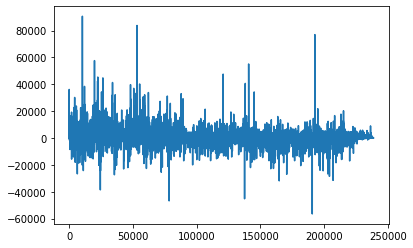

In [65]:
plt.plot(dataset2['VALOR_PROPIO_PROM_12'])

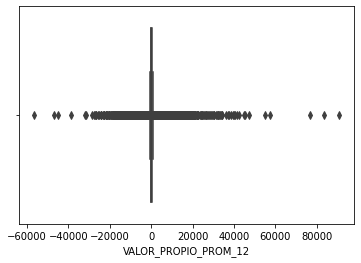

In [66]:
# Grafico un boxplot de la Valoración Promedio Mensual de los últimos 12 meses del cliente para buscar outliers
import seaborn as sns
sns.boxplot(x=dataset2['VALOR_PROPIO_PROM_12'])

In [67]:
# Describo la distribución de la Variable a Explicar (Valoración) para decidir el corte de outliers
dataset2['VALOR_PROPIO_PROM_12'].describe()

count    238751.000000
mean        251.616748
std        1247.379438
min      -56540.010000
25%         -22.170000
50%           2.730000
75%         245.770000
max       90615.750000
Name: VALOR_PROPIO_PROM_12, dtype: float64

In [68]:
dataset2['VALOR_PROPIO_PROM_12'].quantile(0.9995)

16144.026249999999

In [69]:
dataset2['VALOR_PROPIO_PROM_12'].quantile(0.05)

-123.485

In [70]:
# Actualizo el dataset quedandome con el 99,5% de los valores de Valoración a ambos extremos de la distribución
dataset2 = dataset2[np.abs(dataset['VALOR_PROPIO_PROM_12'])<np.abs(dataset2['VALOR_PROPIO_PROM_12'].quantile(0.9995))]

In [71]:
dataset2 = dataset2[dataset2['VALOR_PROPIO_PROM_12']>dataset2['VALOR_PROPIO_PROM_12'].quantile(0.05)]

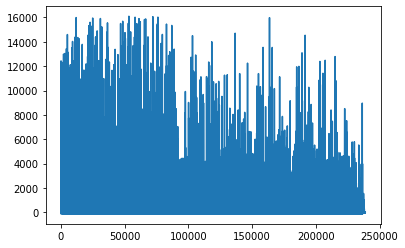

In [72]:
plt.plot(dataset2['VALOR_PROPIO_PROM_12'])

In [73]:
dataset2['VALOR_PROPIO_PROM_12'].describe()

count    226639.000000
mean        309.266584
std         877.513528
min        -122.970000
25%         -19.740000
50%          10.230000
75%         271.670000
max       16092.070000
Name: VALOR_PROPIO_PROM_12, dtype: float64

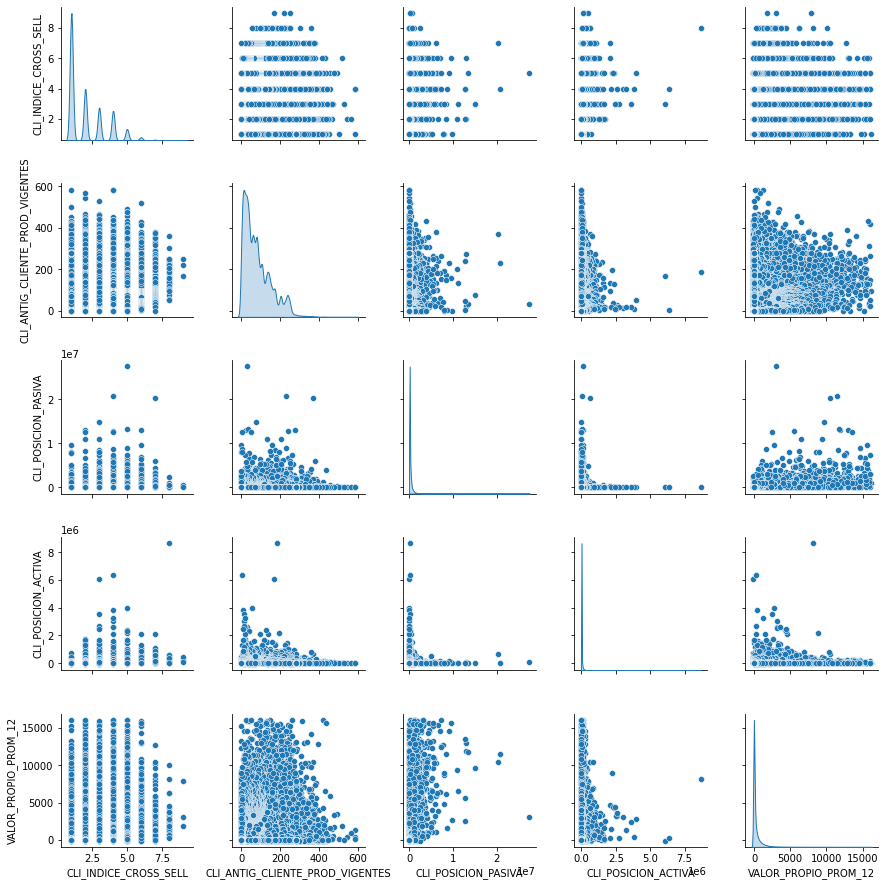

In [74]:
# Grafico la correlación de a pares entre principales variables del dataset]
sns.pairplot(dataset2, vars=["CLI_INDICE_CROSS_SELL", "CLI_ANTIG_CLIENTE_PROD_VIGENTES", "CLI_POSICION_PASIVA","CLI_POSICION_ACTIVA","VALOR_PROPIO_PROM_12"], diag_kind="kde")

In [75]:
dataset2.corr()

,PERIODO,CODIGO_CLIENTE,CLI_INDICE_CROSS_SELL,CLI_ANTIG_CLIENTE_PROD_VIGENTES,CLI_POSICION_PASIVA,CLI_POSICION_ACTIVA,EDAD,CLI_SUCURSAL_SOURCE_RADICACION,CLI_SCORE_DATOS_ADICIONALES,CLI_CANTIDAD_EMPLEADORES,FLAG_CUIT_EMPLEADOR,CLI_INGRESO,ACRED_CUPONES_ULT_3,ANTERIOR_CC_VIGENTE,FLAG_TIENE_ANTERIOR_CC_VIG,ULTIMA_CC_VIGENTE,FLAG_TIENE_ULTIMA_CC_VIG,FLAG_CALIF_CTE,CC,DV_ANT_SALDO_NEGATIVO_3,DV_ANT_SALDO_NEGATIVO_6,DV_ANT_SALDO_NEGATIVO_12,DV_ANT_SALDO_POSITIVO_3,DV_ANT_SALDO_POSITIVO_6,DV_ANT_SALDO_POSITIVO_12,DV_PROM_SALDO,DV_PROM_SALDO_3,DV_PROM_SALDO_6,DV_PROM_SALDO_12,DV_CA_ACRED,DV_CA_EXTRAC,DV_CA_MONTO_TRANS,DV_CA_ACRED_3,DV_CA_EXTRAC_3,DV_CA_MONTO_TRANS_3,FLAG_COMPRA_TD,CLI_DIAS_MORA,CLI_SALDO_DEUDA,CLI_DIAS_SOBREGIRO,CLI_DIAS_ATRASO_BCRA,CLI_FLAG_SITUACION_BANCO_1_3,CLI_FLAG_SITUACION_BANCO_2_3,CLI_FLAG_SITUACION_BANCO_3_3,PF_SALDO,PF_CANT,PF_SALDO_3,PF_CANT_PROM_3,PR_HIPOTECARIOS,PR_PERSONALES,PR_ATRASO_30,PR_ATRASO_60,PR_MONTO_ORIGINAL,PR_MESES_CON_PRESTAMOS,PR_ANTIGUEDAD_PRESTAMOS,PR_MESES_ENTRE_PRESTAMOS,PR_MESES_CON_PERSONALES,PR_PORC_RENOVADOS_RECIENTE,PR_Q_RENOVADOS_RECIENTE,FLAG_CUENTA_TC,FLAG_CA,FLAG_CA_USD,FLAG_CC,FLAG_TD,FLAG_SEGURO,FLAG_PAQUETE_BI,VALOR_PROPIO_PROM_1,VALOR_PROPIO_PROM_3,VALOR_PROPIO_PROM_6,VALOR_PROPIO_PROM_12,VALOR_PROPIO_PROM_1.1,VALOR_PROPIO_PROM_3.1
PERIODO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CODIGO_CLIENTE,NaN,1.000000,-0.334193,-0.744932,-0.092468,-0.202765,-0.456765,0.139610,-0.094894,-0.086531,-0.085279,-0.239937,0.001028,-0.231474,-0.231474,-0.231474,-0.231474,-0.238434,-0.238434,0.135139,0.165409,0.175611,0.051431,0.051227,0.049757,-0.070612,-0.072594,-0.082777,-0.098840,-0.225775,-0.178390,-0.022411,-0.230896,-0.166471,-0.024020,-0.128569,-0.107846,-0.201465,-0.123803,-0.123803,-0.295306,-0.007369,-0.001949,-0.070642,-0.102619,-0.071459,-0.107146,-0.008881,-0.207835,-0.007319,-0.008493,-0.197303,-0.334996,-0.344754,-0.155798,-0.334626,-0.186816,-0.188190,-0.288960,0.066387,-0.075608,-0.243002,-0.024870,-0.203161,-0.226196,-0.134756,-0.177978,-0.207771,-0.242167,-0.093487,-0.136263
CLI_INDICE_CROSS_SELL,NaN,-0.334193,1.000000,0.359172,0.111178,0.478927,0.218300,-0.054018,0.128608,0.188499,0.198818,0.274388,0.037265,0.139623,0.139623,0.139623,0.139623,0.217338,0.217338,-0.033297,-0.095209,-0.118372,-0.098095,-0.098002,-0.094260,0.103250,0.108962,0.121553,0.138003,0.365036,0.294903,0.067266,0.368536,0.292597,0.061551,0.317380,-0.037722,0.479158,-0.046119,-0.046119,0.714699,0.031188,0.000031,0.083196,0.141676,0.081757,0.137146,0.038771,0.571791,0.013689,0.005854,0.476453,0.598386,0.598341,0.221784,0.597928,0.403809,0.353262,0.674310,0.205480,0.386309,0.683796,0.267983,0.723037,0.710037,0.170992,0.238600,0.284897,0.335873,0.098700,0.146793
CLI_ANTIG_CLIENTE_PROD_VIGENTES,NaN,-0.744932,0.359172,1.000000,0.076528,0.213491,0.411070,-0.052972,0.108672,0.089073,0.087284,0.269261,0.004575,0.223684,0.223684,0.223684,0.223684,0.242923,0.242923,-0.127168,-0.156647,-0.166947,-0.052347,-0.052638,-0.051468,0.084184,0.087866,0.100575,0.119504,0.214414,0.187177,0.032186,0.221005,0.179411,0.034066,0.126666,0.113933,0.212110,0.161884,0.161884,0.355094,0.007506,-0.001266,0.049683,0.055424,0.050557,0.057805,0.011935,0.198617,0.001521,0.003130,0.195722,0.333335,0.339465,0.135711,0.332713,0.182645,0.185018,0.340571,-0.053580,0.077356,0.257098,0.031801,0.215468,0.233175,0.121273,0.167831,0.202325,0.242191,0.090738,0.123508
CLI_POSICION_PASIVA,NaN,-0.092468,0.111178,0.076528,1.000000,0.002470,0.114598,0.036091,0.036009,-0.005605,-0.008683,0.132421,0.007563,0.091088,0.091088,0.091088,0.091088,0.118367,0.118367,-0.002508,-0.001283,-0.000901,-0.028403,-0.026725,-0.026216,0.357988,0.360324,0.375977,0.384108,0.018517,0.029787,0.136356,0.018591,0.023380,0.105965,0.068048,

In [76]:
# Como muchas variables son categóricas o nominales, genero dummies para cada una de ellas.
dummies = pd.get_dummies(dataset2, columns=['CLI_SEXO','CLI_CATEGORIA','CLI_SITUACION_BCRA','CLI_CODIGO_IVA','CLI_SEGMENTO_COMERCIAL','CLI_SUB_SEGMENTO_COMERCIAL','CLI_INGRESO_CONSIDERADO','DIVISION_SUCURSAL'])

In [77]:
dummies.head()

,PERIODO,CODIGO_CLIENTE,CLI_INDICE_CROSS_SELL,CLI_ANTIG_CLIENTE_PROD_VIGENTES,CLI_POSICION_PASIVA,CLI_POSICION_ACTIVA,EDAD,CLI_SUCURSAL_SOURCE_RADICACION,CLI_SEGMENTO,CLI_SUB_SEGMENTO,CLI_SCORE_DATOS_ADICIONALES,CLI_CANTIDAD_EMPLEADORES,FLAG_CUIT_EMPLEADOR,CLI_INGRESO,ACRED_CUPONES_ULT_3,ANTERIOR_CC_VIGENTE,FLAG_TIENE_ANTERIOR_CC_VIG,ULTIMA_CC_VIGENTE,FLAG_TIENE_ULTIMA_CC_VIG,FLAG_CALIF_CTE,CC,DV_ANT_SALDO_NEGATIVO_3,DV_ANT_SALDO_NEGATIVO_6,DV_ANT_SALDO_NEGATIVO_12,DV_ANT_SALDO_POSITIVO_3,DV_ANT_SALDO_POSITIVO_6,DV_ANT_SALDO_POSITIVO_12,DV_PROM_SALDO,DV_PROM_SALDO_3,DV_PROM_SALDO_6,DV_PROM_SALDO_12,DV_CA_ACRED,DV_CA_EXTRAC,DV_CA_MONTO_TRANS,DV_CA_ACRED_3,DV_CA_EXTRAC_3,DV_CA_MONTO_TRANS_3,FLAG_COMPRA_TD,CLI_DIAS_MORA,CLI_SALDO_DEUDA,...,CLI_SEGMENTO_COMERCIAL_JUBILADOS,CLI_SEGMENTO_COMERCIAL_MERCADO ABIERTO,CLI_SEGMENTO_COMERCIAL_OTROS SEGMENTOS ESPECIALES,CLI_SEGMENTO_COMERCIAL_PLAN SUELDO PRIVADO,CLI_SEGMENTO_COMERCIAL_PLAN SUELDO PUBLICO,CLI_SEGMENTO_COMERCIAL_PROFESIONALES Y NEGOCIOS,CLI_SUB_SEGMENTO_COMERCIAL_ASIGNACIONES FAMILIARES,CLI_SUB_SEGMENTO_COMERCIAL_AUH,CLI_SUB_SEGMENTO_COMERCIAL_COMERCIANTE,CLI_SUB_SEGMENTO_COMERCIAL_EMPLEADO BANCO,CLI_SUB_SEGMENTO_COMERCIAL_JUBILADOS NACIONALES,CLI_SUB_SEGMENTO_COMERCIAL_JUBILADOS PROVINCIALES,CLI_SUB_SEGMENTO_COMERCIAL_MERCADO ABIERTO,CLI_SUB_SEGMENTO_COMERCIAL_PENSION GRACIABLE,"CLI_SUB_SEGMENTO_COMERCIAL_PROD. TABACALEROS, YERBATEROS",CLI_SUB_SEGMENTO_COMERCIAL_PROFESIONAL INDEPENDIENTE,CLI_SUB_SEGMENTO_COMERCIAL_PROGRESAR,CLI_SUB_SEGMENTO_COMERCIAL_PROVEEDORES DE SERVICIOS,CLI_SUB_SEGMENTO_COMERCIAL_PS PRIVADO A,CLI_SUB_SEGMENTO_COMERCIAL_PS PRIVADO B,CLI_SUB_SEGMENTO_COMERCIAL_PS PRIVADO C,CLI_SUB_SEGMENTO_COMERCIAL_PS PRIVADO E,CLI_SUB_SEGMENTO_COMERCIAL_PS PUBLICO MUNICIPAL,CLI_SUB_SEGMENTO_COMERCIAL_PS PUBLICO PROVINCIAL,CLI_SUB_SEGMENTO_COMERCIAL_SMSV,CLI_INGRESO_CONSIDERADO_CC,CLI_INGRESO_CONSIDERADO_COM,CLI_INGRESO_CONSIDERADO_DA,CLI_INGRESO_CONSIDERADO_SIN,DIVISION_SUCURSAL_A DETERMINAR,DIVISION_SUCURSAL_AMBA,DIVISION_SUCURSAL_CASA MATRIZ,DIVISION_SUCURSAL_CORDOBA,DIVISION_SUCURSAL_JUJUY,DIVISION_SUCURSAL_NEA,DIVISION_SUCURSAL_PROVINCIA BS. AS.,DIVISION_SUCURSAL_SALTA,DIVISION_SUCURSAL_SANTA FE,DIVISION_SUCURSAL_SUROESTE,DIVISION_SUCURSAL_TUCUMAN
0,201810,196,1,41,25056.09,0.00,83,13,Jubilados/Pensionados,Jubilados/Pensionados Anses,0.00,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,12.0,12.0,12.0,0.0,0.0,0.0,25125.78,25031.40,24601.13,23850.78,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.00,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,201810,192,3,199,7.97,5522.94,47,18,Jubilados/Pensionados,Jubilados/Pensionados Anses,0.00,0,0,7161.0,0,0.0,0.0,0.0,0.0,0,0.0,12.0,12.0,12.0,0.0,0.0,0.0,231.67,425.78,649.24,680.38,1.0,2.0,0.0,3.0,6.0,0.0,1,0.0,5522.94,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,201810,95,2,175,58818.93,0.00,76,27,Profesionales Y Negocios,"Prod. Tabacaleros, Yerbateros",0.00,0,0,8029.0,0,0.0,0.0,0.0,0.0,0,0.0,12.0,12.0,12.0,0.0,0.0,0.0,66455.22,131153.81,160962.94,137332.70,1.0,2.0,0.0,1.0,2.0,0.0,1,0.0,0.00,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,201810,94,1,189,366.48,0.00,66,5,Plan Sueldo,Empresas Privadas A,0.00,0,0,11203.0,0,41.0,1.0,41.0,1.0,0,0.0,12.0,12.0,12.0,0.0,0.0,0.0,1158.33,931.40,1303.35,12770.62,1.0,6.0,0.0,3.0,12.0,0.0,1,0.0,0.00,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,201810,92,5,237,684140.84,0.00,66,27,Jubilados/Pensionados,Jubilados/Pensionados Anses,21866.55,1,1,21153.0,0,41.0,1.0,41.0,1.0,1,42.0,12.0,12.0,12.0,0.0,0.0,0.0,363689.60,462180.12,499094.84,443578.60,2.0,0.0,0.0,6.0,0.0,0.0,1,0.0,0.00,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [78]:
# Elimino dos variables que desactualizadas (segmento y subsegmento, ya que me quedo con segmento y subsegmento comercial)
dataset2 = dummies.drop(['CLI_SEGMENTO','CLI_SUB_SEGMENTO'], axis=1)

In [79]:
dataset2.head()

,PERIODO,CODIGO_CLIENTE,CLI_INDICE_CROSS_SELL,CLI_ANTIG_CLIENTE_PROD_VIGENTES,CLI_POSICION_PASIVA,CLI_POSICION_ACTIVA,EDAD,CLI_SUCURSAL_SOURCE_RADICACION,CLI_SCORE_DATOS_ADICIONALES,CLI_CANTIDAD_EMPLEADORES,FLAG_CUIT_EMPLEADOR,CLI_INGRESO,ACRED_CUPONES_ULT_3,ANTERIOR_CC_VIGENTE,FLAG_TIENE_ANTERIOR_CC_VIG,ULTIMA_CC_VIGENTE,FLAG_TIENE_ULTIMA_CC_VIG,FLAG_CALIF_CTE,CC,DV_ANT_SALDO_NEGATIVO_3,DV_ANT_SALDO_NEGATIVO_6,DV_ANT_SALDO_NEGATIVO_12,DV_ANT_SALDO_POSITIVO_3,DV_ANT_SALDO_POSITIVO_6,DV_ANT_SALDO_POSITIVO_12,DV_PROM_SALDO,DV_PROM_SALDO_3,DV_PROM_SALDO_6,DV_PROM_SALDO_12,DV_CA_ACRED,DV_CA_EXTRAC,DV_CA_MONTO_TRANS,DV_CA_ACRED_3,DV_CA_EXTRAC_3,DV_CA_MONTO_TRANS_3,FLAG_COMPRA_TD,CLI_DIAS_MORA,CLI_SALDO_DEUDA,CLI_DIAS_SOBREGIRO,CLI_DIAS_ATRASO_BCRA,...,CLI_SEGMENTO_COMERCIAL_JUBILADOS,CLI_SEGMENTO_COMERCIAL_MERCADO ABIERTO,CLI_SEGMENTO_COMERCIAL_OTROS SEGMENTOS ESPECIALES,CLI_SEGMENTO_COMERCIAL_PLAN SUELDO PRIVADO,CLI_SEGMENTO_COMERCIAL_PLAN SUELDO PUBLICO,CLI_SEGMENTO_COMERCIAL_PROFESIONALES Y NEGOCIOS,CLI_SUB_SEGMENTO_COMERCIAL_ASIGNACIONES FAMILIARES,CLI_SUB_SEGMENTO_COMERCIAL_AUH,CLI_SUB_SEGMENTO_COMERCIAL_COMERCIANTE,CLI_SUB_SEGMENTO_COMERCIAL_EMPLEADO BANCO,CLI_SUB_SEGMENTO_COMERCIAL_JUBILADOS NACIONALES,CLI_SUB_SEGMENTO_COMERCIAL_JUBILADOS PROVINCIALES,CLI_SUB_SEGMENTO_COMERCIAL_MERCADO ABIERTO,CLI_SUB_SEGMENTO_COMERCIAL_PENSION GRACIABLE,"CLI_SUB_SEGMENTO_COMERCIAL_PROD. TABACALEROS, YERBATEROS",CLI_SUB_SEGMENTO_COMERCIAL_PROFESIONAL INDEPENDIENTE,CLI_SUB_SEGMENTO_COMERCIAL_PROGRESAR,CLI_SUB_SEGMENTO_COMERCIAL_PROVEEDORES DE SERVICIOS,CLI_SUB_SEGMENTO_COMERCIAL_PS PRIVADO A,CLI_SUB_SEGMENTO_COMERCIAL_PS PRIVADO B,CLI_SUB_SEGMENTO_COMERCIAL_PS PRIVADO C,CLI_SUB_SEGMENTO_COMERCIAL_PS PRIVADO E,CLI_SUB_SEGMENTO_COMERCIAL_PS PUBLICO MUNICIPAL,CLI_SUB_SEGMENTO_COMERCIAL_PS PUBLICO PROVINCIAL,CLI_SUB_SEGMENTO_COMERCIAL_SMSV,CLI_INGRESO_CONSIDERADO_CC,CLI_INGRESO_CONSIDERADO_COM,CLI_INGRESO_CONSIDERADO_DA,CLI_INGRESO_CONSIDERADO_SIN,DIVISION_SUCURSAL_A DETERMINAR,DIVISION_SUCURSAL_AMBA,DIVISION_SUCURSAL_CASA MATRIZ,DIVISION_SUCURSAL_CORDOBA,DIVISION_SUCURSAL_JUJUY,DIVISION_SUCURSAL_NEA,DIVISION_SUCURSAL_PROVINCIA BS. AS.,DIVISION_SUCURSAL_SALTA,DIVISION_SUCURSAL_SANTA FE,DIVISION_SUCURSAL_SUROESTE,DIVISION_SUCURSAL_TUCUMAN
0,201810,196,1,41,25056.09,0.00,83,13,0.00,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,12.0,12.0,12.0,0.0,0.0,0.0,25125.78,25031.40,24601.13,23850.78,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.00,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,201810,192,3,199,7.97,5522.94,47,18,0.00,0,0,7161.0,0,0.0,0.0,0.0,0.0,0,0.0,12.0,12.0,12.0,0.0,0.0,0.0,231.67,425.78,649.24,680.38,1.0,2.0,0.0,3.0,6.0,0.0,1,0.0,5522.94,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,201810,95,2,175,58818.93,0.00,76,27,0.00,0,0,8029.0,0,0.0,0.0,0.0,0.0,0,0.0,12.0,12.0,12.0,0.0,0.0,0.0,66455.22,131153.81,160962.94,137332.70,1.0,2.0,0.0,1.0,2.0,0.0,1,0.0,0.00,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,201810,94,1,189,366.48,0.00,66,5,0.00,0,0,11203.0,0,41.0,1.0,41.0,1.0,0,0.0,12.0,12.0,12.0,0.0,0.0,0.0,1158.33,931.40,1303.35,12770.62,1.0,6.0,0.0,3.0,12.0,0.0,1,0.0,0.00,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,201810,92,5,237,684140.84,0.00,66,27,21866.55,1,1,21153.0,0,41.0,1.0,41.0,1.0,1,42.0,12.0,12.0,12.0,0.0,0.0,0.0,363689.60,462180.12,499094.84,443578.60,2.0,0.0,0.0,6.0,0.0,0.0,1,0.0,0.00,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [80]:
# Genero un sub data set para evaluar la correlación entre todas las variables con la Valoración Promedio Mensual de 12 meses
dataset3 = dummies.drop(['PERIODO','CODIGO_CLIENTE','VALOR_PROPIO_PROM_1','VALOR_PROPIO_PROM_3','VALOR_PROPIO_PROM_6','VALOR_PROPIO_PROM_1.1',
'VALOR_PROPIO_PROM_3.1'],axis=1)

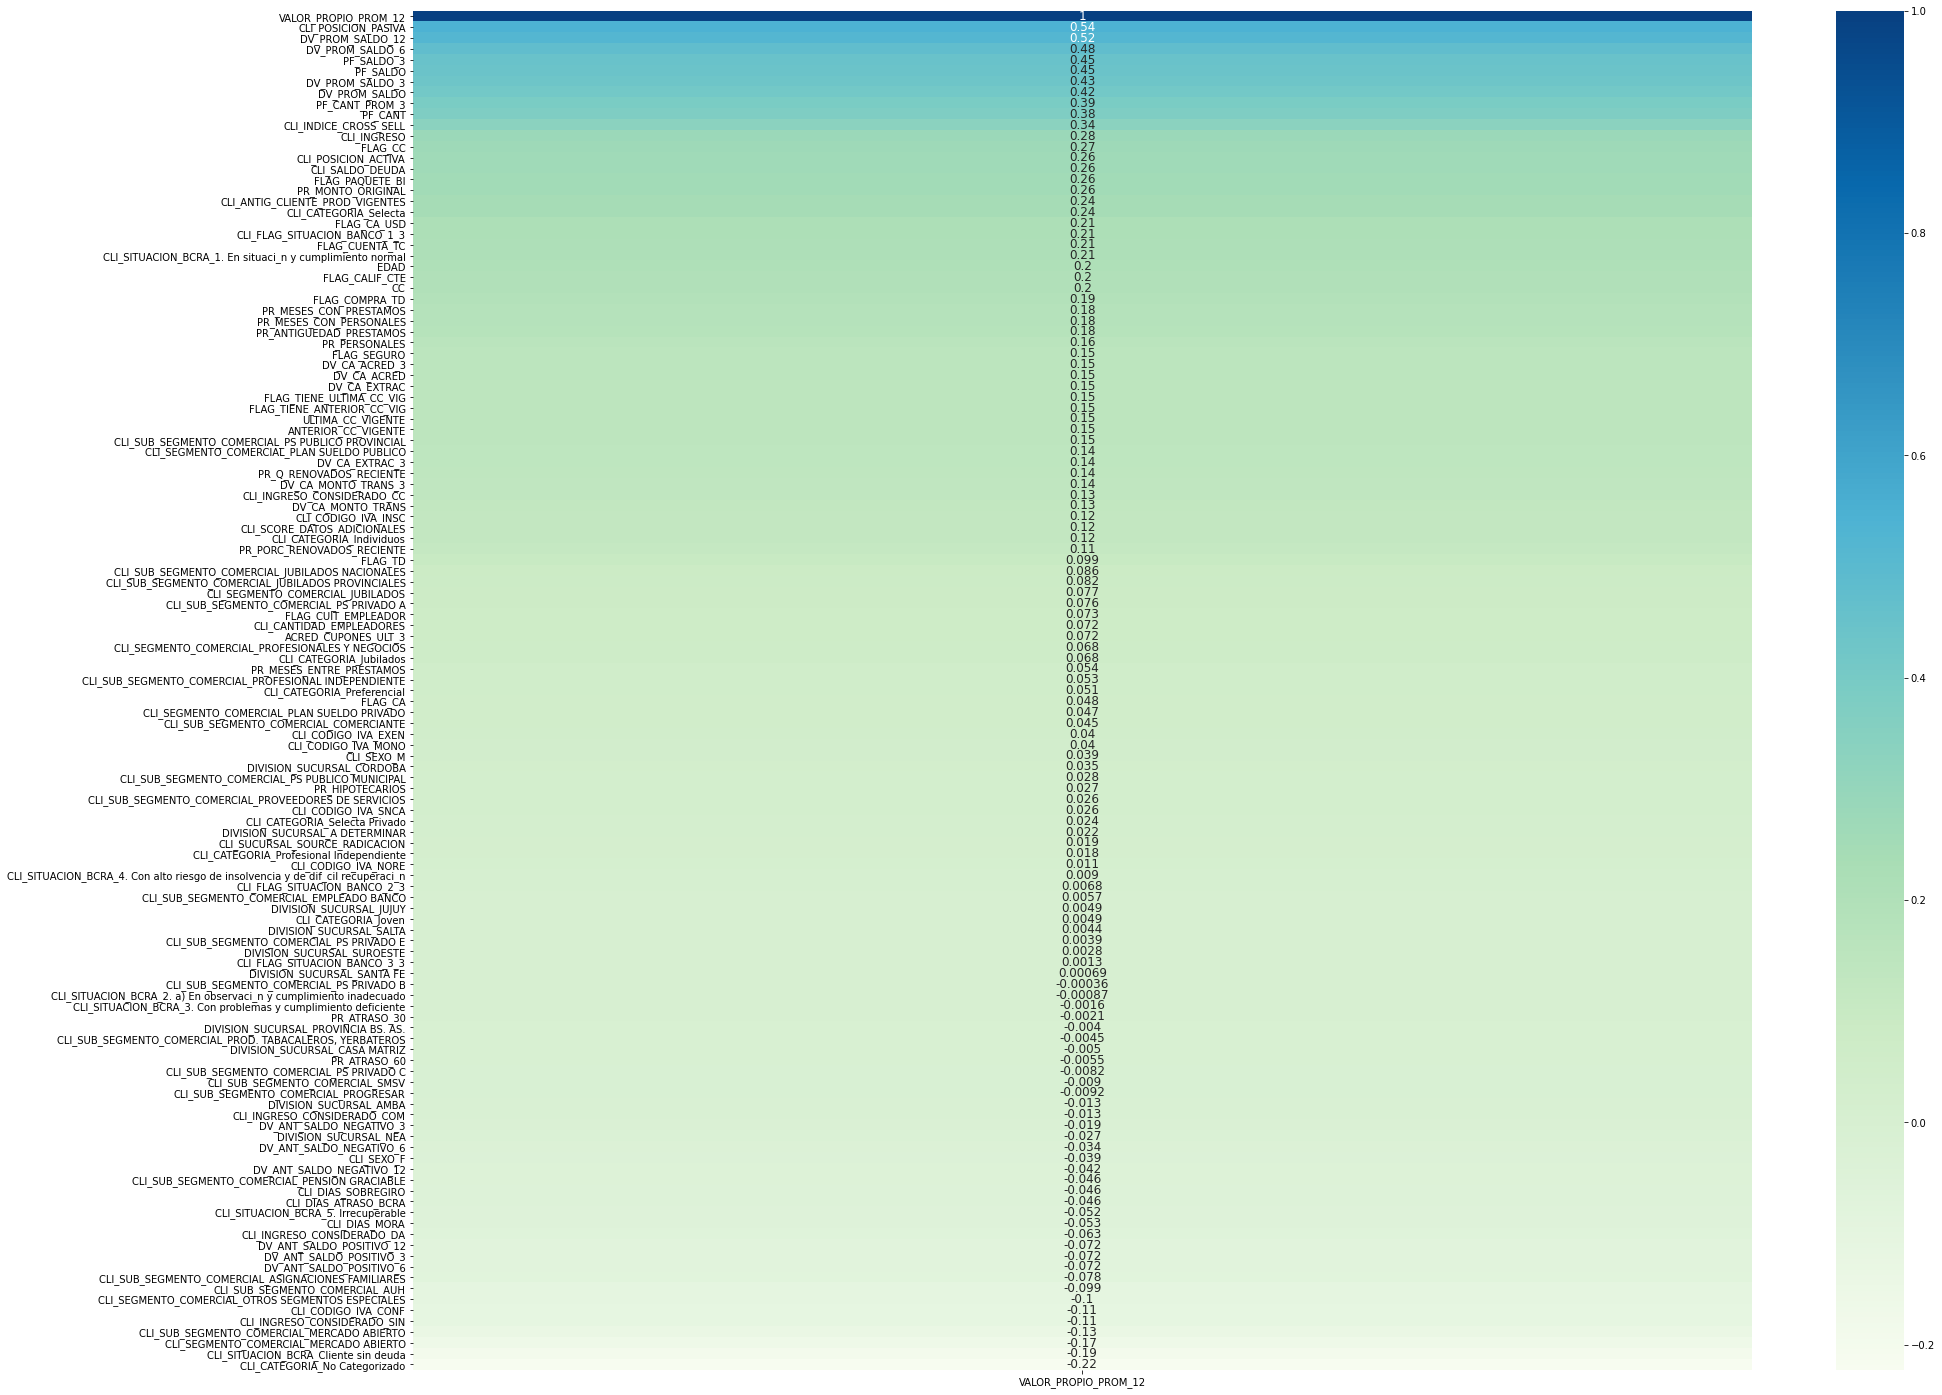

In [81]:
# Realizo un cuadro para evaluar la correlación de todas las variables respecto de Valoración Promedio Mensual de 12 meses
df_corr_valoracion = dataset3.corr()['VALOR_PROPIO_PROM_12'][:-1].sort_values(ascending=False)
#set fig size
fig, ax = plt.subplots(figsize=(30,25))
#plot matrix
sns.heatmap(df_corr_valoracion.to_frame(),annot=True, annot_kws={'size':12},cmap="GnBu")
plt.show();

In [82]:
# Creo una función para ordenar los cluster numéricos
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [83]:
# Entreno cluster de Valoración Promedio 12 meses
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5)
y=dataset3['VALOR_PROPIO_PROM_12']
y=y.values.reshape(-1,1)
km.fit(y)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

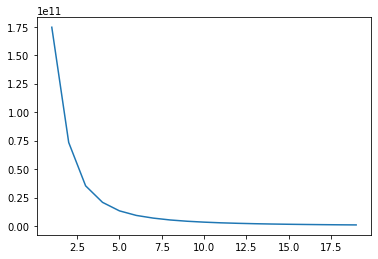

In [84]:
# Chequeo con la técnica del codo la cantidad óptima de clusters
n = range(1,20)
KMScore = []
for i in n:
    
    km = KMeans(n_clusters=i)
    km.fit(y)
    KMScore.append(km.inertia_)
import matplotlib.pyplot as plt
plt.plot(n,KMScore);

In [85]:
# Creo el cluster y lo agrego al dataset
km = KMeans(n_clusters=5)
km.fit(y)
dataset3['VALOR12Cluster'] = km.predict(y)

In [86]:
# Creo un nuevo dataset para analizar cómo agrupó los valores el cluster
dataset_cluster = dataset3.copy()
dataset_cluster = order_cluster('VALOR12Cluster', 'VALOR_PROPIO_PROM_12',dataset_cluster ,True)
dataset_cluster.groupby('VALOR12Cluster')['VALOR_PROPIO_PROM_12'].describe()

,count,mean,std,min,25%,50%,75%,max
VALOR12Cluster,,,,,,,,
0,183466.0,41.018434,115.665460,-122.97,-23.0600,-6.63,73.2075,429.76
1,31247.0,816.990593,294.372205,429.79,562.5550,752.04,1032.9250,1503.69
2,9149.0,2186.524833,555.597372,1503.76,1729.6500,2030.91,2540.7100,3629.11
3,2251.0,5068.855997,1122.751447,3630.65,4116.5000,4814.41,5821.9100,7877.79
4,526.0,10690.809011,2187.978104,7886.64,8855.9825,10212.63,12083.6800,16092.07


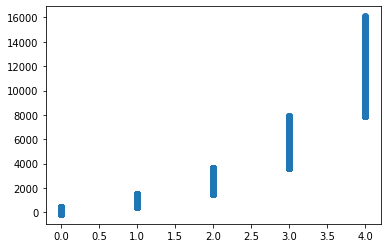

In [87]:
# Evaluo gráficamente la distribución de valores del Cluster 
plt.plot(dataset_cluster['VALOR12Cluster'], dataset_cluster['VALOR_PROPIO_PROM_12'],'o')

In [88]:
# Entreno cluster de Posición Pasiva
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4)
a=dataset3['CLI_POSICION_PASIVA']
a=a.values.reshape(-1,1)
km.fit(a)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

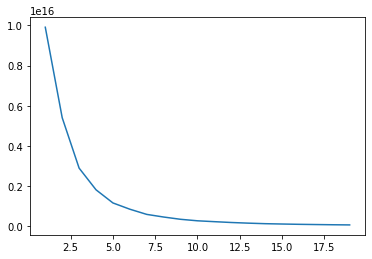

In [89]:
# Chequeo con la técnica del codo la cantidad óptima de clusters
n = range(1,20)
KMScore = []
for i in n:
    
    km = KMeans(n_clusters=i)
    km.fit(a)
    KMScore.append(km.inertia_)
import matplotlib.pyplot as plt
plt.plot(n,KMScore);

In [90]:
# Creo el cluster y lo agrego al dataset
km = KMeans(n_clusters=4)
km.fit(a)
dataset3['POSICIONPASIVACluster'] = km.predict(a)

In [91]:
# Creo un nuevo dataset para analizar cómo agrupó los valores el cluster
dataset_cluster = dataset3.copy()
dataset_cluster = order_cluster('POSICIONPASIVACluster', 'CLI_POSICION_PASIVA',dataset_cluster ,True)
dataset_cluster.groupby('POSICIONPASIVACluster')['CLI_POSICION_PASIVA'].describe()

,count,mean,std,min,25%,50%,75%,max
POSICIONPASIVACluster,,,,,,,,
0,222341.0,1.148363e+04,3.957252e+04,0.00,0.830,40.12,1.966000e+03,359794.26
1,3885.0,7.076564e+05,3.267858e+05,359896.33,450092.760,600515.69,8.745137e+05,1744419.85
2,391.0,2.790152e+06,1.170396e+06,1755010.52,2012620.320,2318903.56,3.121514e+06,7337525.30
3,22.0,1.218972e+07,4.976479e+06,7811731.76,8459034.135,11018870.97,1.301086e+07,27467196.11


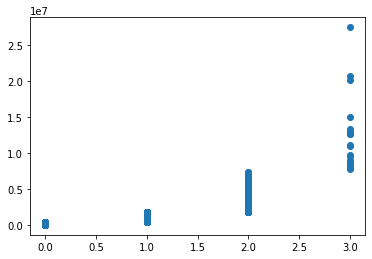

In [92]:
# Evaluo gráficamente la distribución de valores del Cluster 
plt.plot(dataset_cluster['POSICIONPASIVACluster'], dataset_cluster['CLI_POSICION_PASIVA'],'o')

In [93]:
# Entreno cluster de Cross Sell
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5)
b=dataset2['CLI_INDICE_CROSS_SELL']
b=b.values.reshape(-1,1)
km.fit(b)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

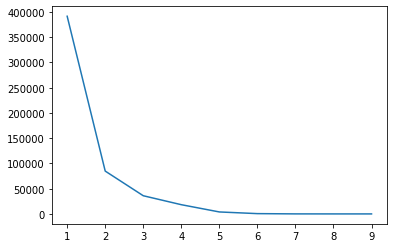

In [94]:
# Chequeo con la técnica del codo la cantidad óptima de clusters
n = range(1,10)
KMScore = []
for i in n:
    
    km = KMeans(n_clusters=i)
    km.fit(b)
    KMScore.append(km.inertia_)
import matplotlib.pyplot as plt
plt.plot(n,KMScore);

In [95]:
# Creo el cluster y lo agrego al dataset
km = KMeans(n_clusters=5)
km.fit(b)
dataset3['CROSSELLCluster'] = km.predict(b)

In [96]:
# Creo un nuevo dataset para analizar cómo agrupó los valores el cluster
dataset_cluster = dataset3.copy()
dataset_cluster = order_cluster('CROSSELLCluster', 'CLI_INDICE_CROSS_SELL',dataset_cluster ,True)
#see details of the clusters
dataset_cluster.groupby('CROSSELLCluster')['CLI_INDICE_CROSS_SELL'].describe()

,count,mean,std,min,25%,50%,75%,max
CROSSELLCluster,,,,,,,,
0,112703.0,1.000000,0.00000,1.0,1.0,1.0,1.0,1.0
1,45565.0,2.000000,0.00000,2.0,2.0,2.0,2.0,2.0
2,29031.0,3.000000,0.00000,3.0,3.0,3.0,3.0,3.0
3,26171.0,4.000000,0.00000,4.0,4.0,4.0,4.0,4.0
4,13169.0,5.281039,0.54358,5.0,5.0,5.0,5.0,9.0


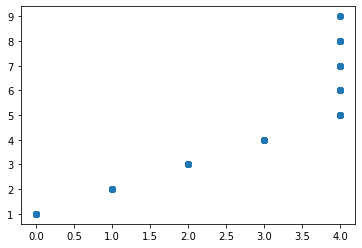

In [97]:
# Evaluo gráficamente la distribución de valores del Cluster 
plt.plot(dataset_cluster['CROSSELLCluster'], dataset_cluster['CLI_INDICE_CROSS_SELL'],'o')

In [98]:
# Entreno cluster de Ingreso
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5)
c=dataset3['CLI_INGRESO']
c=c.values.reshape(-1,1)
km.fit(c)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

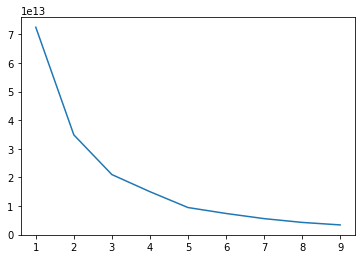

In [99]:
# Chequeo con la técnica del codo la cantidad óptima de clusters
n = range(1,10)
KMScore = []
for i in n:
    
    km = KMeans(n_clusters=i)
    km.fit(c)
    KMScore.append(km.inertia_)
import matplotlib.pyplot as plt
plt.plot(n,KMScore);

In [100]:
# Creo el cluster y lo agrego al dataset
km = KMeans(n_clusters=5)
km.fit(c)
dataset3['INGRESOCluster'] = km.predict(c)

In [101]:
#creatinga new cluster dataframe
dataset_cluster = dataset3.copy()
dataset_cluster = order_cluster('INGRESOCluster', 'CLI_INGRESO',dataset_cluster ,True)
#see details of the clusters
dataset_cluster.groupby('INGRESOCluster')['CLI_INGRESO'].describe()

,count,mean,std,min,25%,50%,75%,max
INGRESOCluster,,,,,,,,
0,122088.0,6064.433998,4262.598166,0.0,1439.75,7116.0,9203.0,13350.0
1,71435.0,20631.805418,4549.697550,13351.0,16250.00,20304.0,24069.0,30427.0
2,27821.0,40215.534920,7625.416218,30428.0,34486.00,37962.0,44500.0,62832.0
3,5262.0,85455.568795,20460.212048,62839.0,77547.75,85000.0,85000.0,291711.0
4,33.0,504989.333333,246876.190293,301762.0,342174.00,402587.0,547293.0,1422600.0


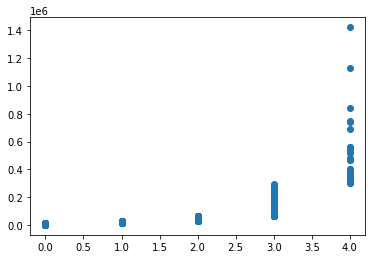

In [102]:
plt.plot(dataset_cluster['INGRESOCluster'], dataset_cluster['CLI_INGRESO'],'o')

In [103]:
# Calculo Score General y utilizo mean() para ver detalles
dataset3['ScoreGeneral'] = dataset3['POSICIONPASIVACluster'] + dataset3['CROSSELLCluster'] + dataset3['INGRESOCluster']
dataset3.groupby('ScoreGeneral')['CLI_POSICION_PASIVA','CLI_INDICE_CROSS_SELL','CLI_INGRESO','VALOR_PROPIO_PROM_12'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,CLI_POSICION_PASIVA,CLI_INDICE_CROSS_SELL,CLI_INGRESO,VALOR_PROPIO_PROM_12
ScoreGeneral,,,,
0,4.316046e+03,1.000000,5263.364423,26.739049
1,1.248634e+05,4.475291,10659.836079,837.283439
2,1.446653e+04,2.176507,21333.039411,219.849179
3,1.601401e+04,1.732369,16006.197639,207.940316
4,4.235011e+04,3.918839,23832.993438,609.378388
5,4.806356e+04,2.777443,29566.042335,569.604146
6,5.096764e+04,2.471571,27694.101793,563.485544
7,7.454355e+04,3.756371,27739.373333,823.222879
8,4.860333e+05,3.928707,70350.570342,2460.053926


In [104]:
# Agrupo por nombres a los grupos de score, siendo 0 el cliente menos rentable bajo y 11 el mejor cliente
dataset3['Segmento'] = 1
dataset3.loc[dataset3['ScoreGeneral']>3,'Segmento'] = 2
dataset3.loc[dataset3['ScoreGeneral']>7,'Segmento'] = 3

In [105]:
dataset3.groupby('Segmento')['VALOR_PROPIO_PROM_12'].mean()

Segmento
1     127.057355
2     621.990880
3    3058.694420
Name: VALOR_PROPIO_PROM_12, dtype: float64

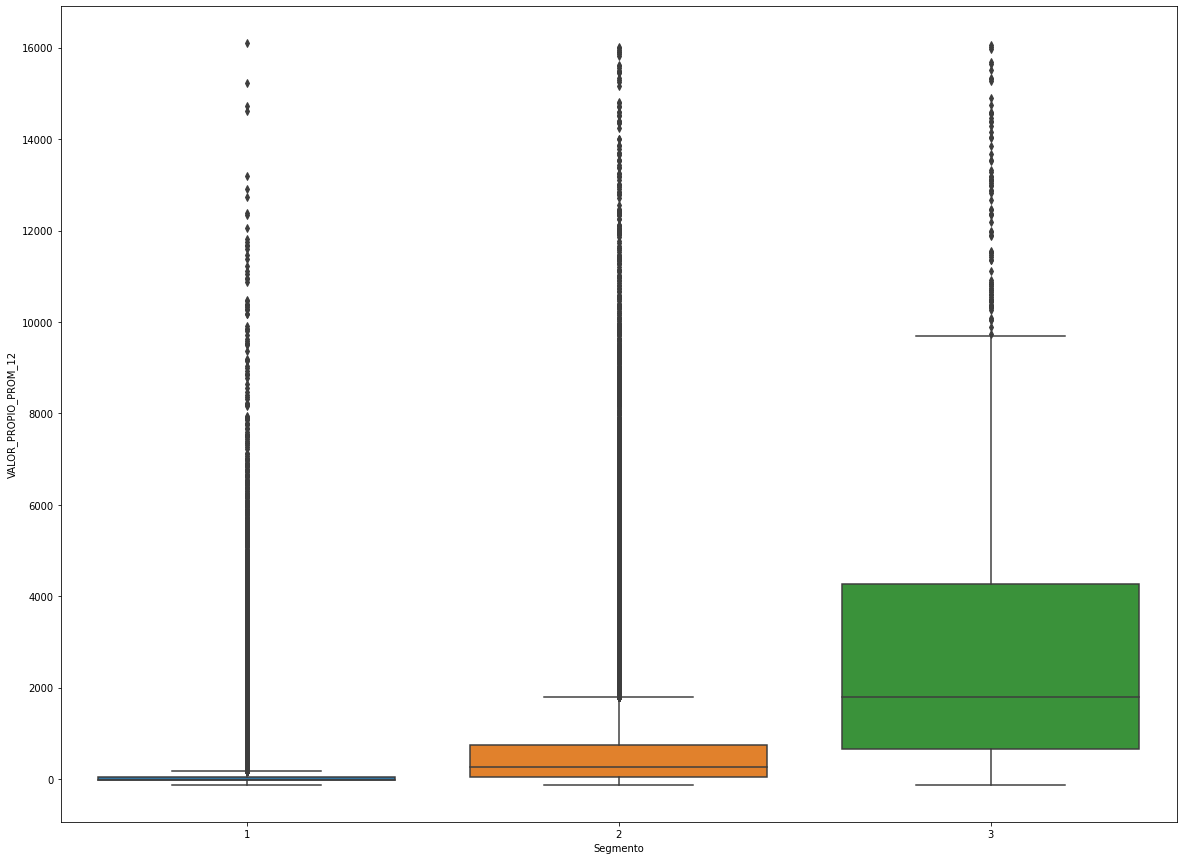

In [106]:
import seaborn as sns
plt.figure(figsize=(20, 15))

sns.boxplot(
    x = 'Segmento',
    y = 'VALOR_PROPIO_PROM_12',
    data = dataset3
)

La correlación positiva es bastante visible aquí. Los grupos de Segmento Score General mayor tienen mayor valor propio promedio.

Antes de construir el modelo de aprendizaje automático, necesitamos identificar cuál es el tipo de este problema de aprendizaje automático. LTV en sí es un problema de regresión. Un modelo de aprendizaje automático puede predecir el valor de $ del LTV. Pero aquí, queremos segmentos LTV. Porque hace que sea más práctico y fácil comunicarse con otras personas. Al aplicar la agrupación de K-means previamente, pudimos identificar nuestros grupos LTV existentes y construir segmentos encima de ellos.
Teniendo en cuenta que el negocio es parte de este análisis, debemos tratar a los clientes de manera diferente según su LTV previsto. Para este ejemplo, aplicaremos la agrupación en clústeres y tendremos 3 segmentos (el número de segmentos realmente depende de la dinámica y los objetivos de su negocio):

In [107]:
# Convierto columnas categóricas a numéricas
dataset4 = pd.get_dummies(dataset3)

# Calculo y muestro correlaciones
corr_matrix = dataset4.corr()
corr_matrix['VALOR12Cluster'].sort_values(ascending=False)

VALOR12Cluster                                1.000000
VALOR_PROPIO_PROM_12                          0.512256
CLI_INDICE_CROSS_SELL                         0.432743
FLAG_CC                                       0.373151
FLAG_PAQUETE_BI                               0.359898
                                                ...   
CLI_SUB_SEGMENTO_Asig. Familiares (Auh)      -0.145536
CLI_SUB_SEGMENTO_COMERCIAL_MERCADO ABIERTO   -0.177636
CLI_SEGMENTO_COMERCIAL_MERCADO ABIERTO       -0.214736
CLI_SITUACION_BCRA_Cliente sin deuda         -0.291872
CLI_CATEGORIA_No Categorizado                -0.317265
Name: VALOR12Cluster, Length: 181, dtype: float64

Vemos que los puntajes de valor propio, tenencias de productos y Score General serán útiles para nuestros modelos de aprendizaje automático.

In [108]:
# Creo X e y, X será el conjunto de features e y es la etiqueta Cluster LTV
X = dataset4.drop(['VALOR12Cluster','VALOR_PROPIO_PROM_12'],axis=1)
y = dataset4['VALOR12Cluster']

# Hago split en training y test sets
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)



In [109]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=2, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.91
Accuracy of XGB classifier on test set: 0.90
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      9105
           1       0.64      0.53      0.58       476
           2       0.50      0.51      0.51       119
           3       0.71      0.68      0.69      1601
           4       0.54      0.23      0.32        31

    accuracy                           0.90     11332
   macro avg       0.67      0.58      0.61     11332
weighted avg       0.90      0.90      0.90     11332



La precisión y el recall son aceptables para el Cluster 0. Como ejemplo, para el grupo 0 (LTV muy bajo), si el modelo nos dice que este cliente pertenece al grupo 0, 95 de 100 serán correctos (precisión). Y el modelo identifica con éxito el 97% de los clientes reales del clúster 0 (recall). Realmente necesitamos mejorar el modelo para otros grupos. Por ejemplo, apenas detectamos el 50% de los clientes de Cluster 2 (LTV medio). 
Posibles acciones para mejorar esos puntos:
- Agregar más features y mejorar feature engineering
- Probar diferentes modelos que no sean XGBoost
- Aplicar ajuste de hiperparámetros al modelo actual
- Agregue más datos al modelo si es posible
Sin embargo, ya tenemos un modelo de aprendizaje automático que predice los futuros segmentos LTV de nuestros clientes. Podemos adaptar fácilmente nuestras acciones en función de eso. Por ejemplo, no queremos perder clientes con un alto LTV.

In [110]:
# Pruebo otras combinaciones de split y train
X = dataset4.drop(['VALOR12Cluster','VALOR_PROPIO_PROM_12'],axis=1)
y = dataset4['VALOR12Cluster']

# Hago split en training y test sets
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=56)

In [111]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=2, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

In [112]:
#Calculo los indicadores provenientes de la matriz de confusión de cada clase
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.91
Accuracy of XGB classifier on test set: 0.91
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     55150
           1       0.64      0.52      0.58      2760
           2       0.53      0.58      0.56       660
           3       0.70      0.68      0.69      9250
           4       0.72      0.27      0.39       172

    accuracy                           0.91     67992
   macro avg       0.71      0.60      0.64     67992
weighted avg       0.90      0.91      0.90     67992



In [113]:
# Implemento una función de clasification report que me calcula el AUC para cada clase.
import pandas as pd
import numpy as np
from scipy import interp

from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

In [114]:
report_with_auc = class_report(
    y_true=y_test, 
    y_pred=ltv_xgb_model.predict(X_test), 
    y_score=ltv_xgb_model.predict_proba(X_test))

print(report_with_auc)

             precision    recall  f1-score  support     pred       AUC
0             0.954843  0.969266  0.962000  55150.0  55983.0  0.973727
1             0.643750  0.522464  0.576800   2760.0   2240.0  0.972101
2             0.533426  0.580303  0.555878    660.0    718.0  0.985263
3             0.702125  0.682162  0.692000   9250.0   8987.0  0.949394
4             0.718750  0.267442  0.389831    172.0     64.0  0.989346
avg / total   0.903146  0.906518  0.904242  67992.0  67992.0  0.992056


In [115]:
# Dado que la clusterización de 5 Grupos no arroja un buen recall en algunos casos, probamos con 4 clusters de Valor
km = KMeans(n_clusters=4)
y=dataset3['VALOR_PROPIO_PROM_12']
y=y.values.reshape(-1,1)
km.fit(y)
dataset3['VALOR12Cluster_v2'] = km.predict(y)
# Creo un nuevo dataset para analizar cómo agrupó los valores el cluster
dataset_cluster = dataset3.copy()
dataset_cluster = order_cluster('VALOR12Cluster_v2', 'VALOR_PROPIO_PROM_12',dataset_cluster ,True)
dataset_cluster.groupby('VALOR12Cluster_v2')['VALOR_PROPIO_PROM_12'].describe()

,count,mean,std,min,25%,50%,75%,max
VALOR12Cluster_v2,,,,,,,,
0,195114.0,70.160223,161.837061,-122.97,-21.6800,-3.510,111.40,647.54
1,26406.0,1225.438406,474.597920,647.56,831.9450,1097.355,1522.90,2523.51
2,4337.0,3819.619440,1089.748656,2523.91,2918.5800,3509.330,4526.15,6695.38
3,782.0,9562.674514,2424.104430,6697.57,7572.3575,8872.200,10977.83,16092.07


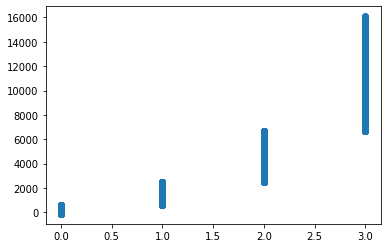

In [116]:
# Evaluo gráficamente la distribución de valores del Cluster 
plt.plot(dataset_cluster['VALOR12Cluster_v2'], dataset_cluster['VALOR_PROPIO_PROM_12'],'o')

In [117]:
# Redefino target de Valor con cluster de 4 grupos
dataset4 = pd.get_dummies(dataset3)
X = dataset4.drop(['VALOR12Cluster_v2','VALOR12Cluster','VALOR_PROPIO_PROM_12'],axis=1)
y = dataset4['VALOR12Cluster_v2']

# Hago split en training y test sets
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=56)

In [118]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=2, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

In [119]:
#Calculo la matriz de confusión
report_with_auc = class_report(
    y_true=y_test, 
    y_pred=ltv_xgb_model.predict(X_test), 
    y_score=ltv_xgb_model.predict_proba(X_test))

print(report_with_auc)

             precision    recall  f1-score  support     pred       AUC
0             0.750302  0.720278  0.734983   7772.0   7461.0  0.964446
1             0.967041  0.975877  0.971439  58658.0  59194.0  0.975708
2             0.726496  0.341365  0.464481    249.0    117.0  0.987036
3             0.625410  0.581112  0.602448   1313.0   1220.0  0.980861
avg / total   0.934787  0.936713  0.935428  67992.0  67992.0  0.994594


In [120]:
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [121]:
# Implemento Random Search sobre XGBoost Multiclassification Model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
random_search = RandomizedSearchCV(ltv_xgb_model, param_distributions=param_grid, scoring='f1_macro', n_jobs=4, cv=5, verbose=3, random_state=1001 )

start_time = timer(None) # timing starts from this point for "start_time" variable
#random_search.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 0 minutes and 0.0 seconds.


In [127]:
random_search.best_params_

AttributeError: ignored

In [ ]:
random_search.best_estimator_

In [ ]:
ltv_xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=5,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1.0, verbosity=1).fit(X_train, y_train)

In [ ]:
report_with_auc = class_report(
y_true=y_test, 
y_pred=ltv_xgb_model.predict(X_test), 
y_score=ltv_xgb_model.predict_proba(X_test))

print(report_with_auc)


In [128]:
#Importo librerías para oversamplear el dataset que se utilizan cuando tengo variables categóricas y continuas
from collections import Counter
from imblearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
# summarize class distribution
print(Counter(y))

Counter({1: 195114, 0: 26406, 3: 4337, 2: 782})


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [129]:
oversample = RandomOverSampler()
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_over))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({1: 195114, 3: 195114, 2: 195114, 0: 195114})


In [134]:
X_over=pd.DataFrame(X_over, columns = X.columns)
X_over.head()

,CLI_INDICE_CROSS_SELL,CLI_ANTIG_CLIENTE_PROD_VIGENTES,CLI_POSICION_PASIVA,CLI_POSICION_ACTIVA,EDAD,CLI_SUCURSAL_SOURCE_RADICACION,CLI_SCORE_DATOS_ADICIONALES,CLI_CANTIDAD_EMPLEADORES,FLAG_CUIT_EMPLEADOR,CLI_INGRESO,ACRED_CUPONES_ULT_3,ANTERIOR_CC_VIGENTE,FLAG_TIENE_ANTERIOR_CC_VIG,ULTIMA_CC_VIGENTE,FLAG_TIENE_ULTIMA_CC_VIG,FLAG_CALIF_CTE,CC,DV_ANT_SALDO_NEGATIVO_3,DV_ANT_SALDO_NEGATIVO_6,DV_ANT_SALDO_NEGATIVO_12,DV_ANT_SALDO_POSITIVO_3,DV_ANT_SALDO_POSITIVO_6,DV_ANT_SALDO_POSITIVO_12,DV_PROM_SALDO,DV_PROM_SALDO_3,DV_PROM_SALDO_6,DV_PROM_SALDO_12,DV_CA_ACRED,DV_CA_EXTRAC,DV_CA_MONTO_TRANS,DV_CA_ACRED_3,DV_CA_EXTRAC_3,DV_CA_MONTO_TRANS_3,FLAG_COMPRA_TD,CLI_DIAS_MORA,CLI_SALDO_DEUDA,CLI_DIAS_SOBREGIRO,CLI_DIAS_ATRASO_BCRA,CLI_FLAG_SITUACION_BANCO_1_3,CLI_FLAG_SITUACION_BANCO_2_3,...,CLI_SUB_SEGMENTO_Asig. Familiares,CLI_SUB_SEGMENTO_Asig. Familiares (Auh),CLI_SUB_SEGMENTO_Asig. Familiares (Progresar),CLI_SUB_SEGMENTO_Clientes De Carteras Compradas,CLI_SUB_SEGMENTO_Comerciante,CLI_SUB_SEGMENTO_Empl. De Empresa Sin Convenio,CLI_SUB_SEGMENTO_Empleado De Macro,CLI_SUB_SEGMENTO_Empresas Privadas A,CLI_SUB_SEGMENTO_Empresas Privadas B,CLI_SUB_SEGMENTO_Empresas Privadas C,CLI_SUB_SEGMENTO_Empresas Privadas Cb,CLI_SUB_SEGMENTO_Empresas Privadas D,CLI_SUB_SEGMENTO_Empresas Privadas E,CLI_SUB_SEGMENTO_Empresas Privadas Ea,CLI_SUB_SEGMENTO_Empresas Privadas Eb,CLI_SUB_SEGMENTO_Empresas Privadas Ee,CLI_SUB_SEGMENTO_Estudiantes,CLI_SUB_SEGMENTO_Ex Empleado Bco Macro,CLI_SUB_SEGMENTO_Funcionarios De Macro,CLI_SUB_SEGMENTO_Jub.Ex-Empl-Macro,CLI_SUB_SEGMENTO_Jub/Pens Afjp-Exterior,CLI_SUB_SEGMENTO_Jubilados No Macro,CLI_SUB_SEGMENTO_Jubilados/Pensionados,CLI_SUB_SEGMENTO_Jubilados/Pensionados Anses,CLI_SUB_SEGMENTO_Org. Publicos Municipales,CLI_SUB_SEGMENTO_Org. Publicos Nacionales,CLI_SUB_SEGMENTO_Org. Publicos Provinciales,CLI_SUB_SEGMENTO_Otros Bancos,CLI_SUB_SEGMENTO_Otros Sin Segmentar,CLI_SUB_SEGMENTO_Pago De Honorarios Ab,CLI_SUB_SEGMENTO_Pago De Honorarios C,CLI_SUB_SEGMENTO_Pago De Honorarios E,CLI_SUB_SEGMENTO_Privados,"CLI_SUB_SEGMENTO_Prod. Tabacaleros, Yerbateros",CLI_SUB_SEGMENTO_Profesional Independiente,CLI_SUB_SEGMENTO_Proveedores De Servicios,CLI_SUB_SEGMENTO_Publicos,CLI_SUB_SEGMENTO_Rentistas,CLI_SUB_SEGMENTO_Smsv-Sociedad Militar Seg.Vida,CLI_SUB_SEGMENTO_Socio O Direct. Emp. Cliente
0,1.0,41.0,25056.09,0.00,83.0,13.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,12.0,12.0,0.0,0.0,0.0,25125.78,25031.40,24601.13,23850.78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,199.0,7.97,5522.94,47.0,18.0,0.00,0.0,0.0,7161.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,12.0,12.0,0.0,0.0,0.0,231.67,425.78,649.24,680.38,1.0,2.0,0.0,3.0,6.0,0.0,1.0,0.0,5522.94,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,175.0,58818.93,0.00,76.0,27.0,0.00,0.0,0.0,8029.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,12.0,12.0,0.0,0.0,0.0,66455.22,131153.81,160962.94,137332.70,1.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,189.0,366.48,0.00,66.0,5.0,0.00,0.0,0.0,11203.0,0.0,41.0,1.0,41.0,1.0,0.0,0.0,12.0,12.0,12.0,0.0,0.0,0.0,1158.33,931.40,1303.35,12770.62,1.0,6.0,0.0,3.0,12.0,0.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,237.0,684140.84,0.00,66.0,27.0,21866.55,1.0,1.0,21153.0,0.0,41.0,1.0,41.0,1.0,1.0,42.0,12.0,12.0,12.0,0.0,0.0,0.0,363689.60,462180.12,499094.84,443578.60,2.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0

In [136]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# define pipeline
steps = [('over', RandomOverSampler()), ('model', ltv_xgb_model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
#score = mean(scores)
#print('F1 Score: %.3f' % score)

In [137]:
X_trainover, X_testover, y_trainover, y_testover = train_test_split(X_over, y_over, test_size=0.3, random_state=56)
ltv_xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=5,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1.0, verbosity=1).fit(X_trainover, y_trainover)

In [138]:
report_with_auc = class_report(
    y_true=y_test, 
    y_pred=ltv_xgb_model.predict(X_test), 
    y_score=ltv_xgb_model.predict_proba(X_test))

print(report_with_auc)

             precision    recall  f1-score  support     pred       AUC
0             0.565288  0.805455  0.664332   7772.0  11074.0  0.940873
1             0.989273  0.918170  0.952396  58658.0  54442.0  0.976990
2             0.416974  0.907631  0.571429    249.0    542.0  0.997516
3             0.478283  0.704494  0.569757   1313.0   1934.0  0.982304
avg / total   0.928845  0.901121  0.910684  67992.0  67992.0  0.985395


In [139]:
# Implemento optimización de hiperparámetros con Randomized Search sobre XGBoost Multiclassification Model en clases balanceadas
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
random_search = RandomizedSearchCV(ltv_xgb_model, param_distributions=param_grid, scoring='f1_macro', n_jobs=4, cv=5, verbose=3, random_state=1001 )

start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_over, y_over)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
exception calling callback for <Future at 0x7f61bab3d9b0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 792, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/joblib/_parallel_backends.py", line 531, in apply_async
  

TerminatedWorkerError: ignored

In [ ]:
i = []
while True:
  i.append(i)

In [ ]:
random.search.best_params_

In [ ]:
random_search.best_estimator_